Variational Autoencoders (VAEs)
======

The VAE implemented here uses the setup found in most VAE papers: a multivariate Normal distribution for the conditional distribution of the latent vectors given and input image ($q_{\phi}(z | x_i)$ in the slides) and a multivariate Bernoulli distribution for the conditional distribution of images given the latent vector ($p_{\theta}(x | z)$ in the slides). Using a Bernoulli distribution, the reconstruction loss (negative log likelihood of a data point in the output distribution) reduces to the pixel-wise binary cross-entropy. See the [original VAE paper](https://arxiv.org/pdf/1312.6114.pdf), Appendix C.1 for details.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!unzip -q '/content/drive/My Drive/car_dataset.zip' -d '/content/'

In [ ]:
# install pytorch (http://pytorch.org/) if run from Google Colaboratory
import sys
if 'google.colab' in sys.modules and 'torch' not in sys.modules:
    from os.path import exists
    from wheel.pep425tags import get_abbr_impl, get_impl_ver, get_abi_tag
    platform = '{}{}-{}'.format(get_abbr_impl(), get_impl_ver(), get_abi_tag())
    cuda_output = !ldconfig -p|grep cudart.so|sed -e 's/.*\.\([0-9]*\)\.\([0-9]*\)$/cu\1\2/'
    accelerator = cuda_output[0] if exists('/dev/nvidia0') else 'cpu'

    !pip3 install https://download.pytorch.org/whl/{accelerator}/torch-1.1.0-{platform}-linux_x86_64.whl
    !pip3 install https://download.pytorch.org/whl/{accelerator}/torchvision-0.3.0-{platform}-linux_x86_64.whl



In [ ]:
!pip install -q torch==1.5.0 torchvision==0.6.0 -f https://download.pytorch.org/whl/torch_stable.html

     |████████████████████████████████| 603.7MB 28kB/s 
     |████████████████████████████████| 6.5MB 30.4MB/s 


In [ ]:
%matplotlib inline
import os
import sys
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import torchvision.datasets as dset
import matplotlib.pyplot as plt
import numpy as np
import torchvision.utils as vutils

Parameter Settings
-------------------


In [ ]:

latent_dims = 128
num_epochs = 100
batch_size = 128
capacity = 64
learning_rate = 1e-3
variational_beta = 1
use_gpu = True
ngf = 32
ndf = 32
ngpu = 1
workers = 2
dataroot = "/content/car_dataset"
nc = 3

CAR Data Loading
-------------------

In [ ]:
dataset = dset.ImageFolder(root=dataroot,
                           transform=transforms.Compose([
                               transforms.Resize(128),
                               transforms.CenterCrop(128),
                               transforms.ToTensor(),
                              #  transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
                           ]))
# Create the dataloader
dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size,
                                         shuffle=True, num_workers=workers)

# Decide which device we want to run on
device = torch.device("cuda:0" if (torch.cuda.is_available() and ngpu > 0) else "cpu")

# Plot some training images
real_batch = next(iter(dataloader))
plt.figure(figsize=(8,8))
plt.axis("off")
plt.title("Training Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:64], padding=2, normalize=True).cpu(),(1,2,0)))

VAE Definition
-----------------------


In [ ]:
class Encoder(nn.Module):
    def __init__(self):
        super(Encoder, self).__init__()
        self.main = nn.Sequential(
          # input is (nc) x 128 x 128
          nn.Conv2d(nc, ndf, 4, stride=2, padding=1, bias=False), 
          nn.LeakyReLU(0.2, inplace=True),
          # state size. (ndf) x 64 x 64
          nn.Conv2d(ndf, ndf * 2, 4, stride=2, padding=1, bias=False),
          nn.BatchNorm2d(ndf * 2),
          nn.LeakyReLU(0.2, inplace=True),
          # state size. (ndf*2) x 32 x 32
          nn.Conv2d(ndf * 2, ndf * 4, 4, stride=2, padding=1, bias=False),
          nn.BatchNorm2d(ndf * 4),
          nn.LeakyReLU(0.2, inplace=True),
          # state size. (ndf*4) x 16 x 16 
          nn.Conv2d(ndf * 4, ndf * 8, 4, stride=2, padding=1, bias=False),
          nn.BatchNorm2d(ndf * 8),
          nn.LeakyReLU(0.2, inplace=True),
          # state size. (ndf*8) x 8 x 8
          nn.Conv2d(ndf * 8, ndf * 16, 4, stride=2, padding=1, bias=False),
          nn.BatchNorm2d(ndf * 16),
          nn.LeakyReLU(0.2, inplace=True),
          # # state size. (ndf*16) x 4 x 4
          # nn.Conv2d(ndf * 16, 1, 4, stride=1, padding=0, bias=False),
          # nn.Sigmoid()
          # # state size. 1
      )
        self.fc_mu = nn.Linear(in_features=ndf * 16 * 4 * 4, out_features=latent_dims)
        self.fc_logvar = nn.Linear(in_features=ndf * 16 * 4 * 4, out_features=latent_dims)
            
    def forward(self, x):
        x = self.main(x)
        x = x.view(x.size(0), -1) # flatten batch of multi-channel feature maps to a batch of feature vectors
        x_mu = self.fc_mu(x)
        x_logvar = self.fc_logvar(x)
        return x_mu, x_logvar

class Decoder(nn.Module):
    def __init__(self):
        super(Decoder, self).__init__()
        # c = capacity
        self.main = nn.Sequential(
            # input is Z, going into a convolution
            nn.ConvTranspose2d(latent_dims, ngf * 16, 4, 1, 0, bias=False),
            nn.BatchNorm2d(ngf * 16),
            nn.ReLU(True),
            # state size. (ngf*16) x 4 x 4
            nn.ConvTranspose2d(ngf * 16, ngf * 8, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 8),
            nn.ReLU(True),
            # state size. (ngf*8) x 8 x 8
            nn.ConvTranspose2d(ngf * 8, ngf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 4),
            nn.ReLU(True),
            # state size. (ngf*4) x 16 x 16 
            nn.ConvTranspose2d(ngf * 4, ngf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 2),
            nn.ReLU(True),
            # state size. (ngf*2) x 32 x 32
            nn.ConvTranspose2d(ngf * 2, ngf, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf),
            nn.ReLU(True),
            # state size. (ngf) x 64 x 64
            nn.ConvTranspose2d(ngf, nc, 4, 2, 1, bias=False),
            # nn.ReLU(True)
            # nn.Tanh()
            # state size. (nc) x 128 x 128
        )
            
    def forward(self, x):
        x = x.view(x.size(0), latent_dims, 1, 1) # unflatten batch of feature vectors to a batch of multi-channel feature maps
        x = torch.sigmoid(self.main(x)) # last layer before output is sigmoid, since we are using BCE as reconstruction loss
        return x
    
class VariationalAutoencoder(nn.Module):
    def __init__(self):
        super(VariationalAutoencoder, self).__init__()
        self.encoder = Encoder()
        self.decoder = Decoder()
    
    def forward(self, x):
        latent_mu, latent_logvar = self.encoder(x)
        latent = self.latent_sample(latent_mu, latent_logvar)
        x_recon = self.decoder(latent)
        return x_recon, latent_mu, latent_logvar
    
    def latent_sample(self, mu, logvar):
        if self.training:
            # the reparameterization trick
            std = logvar.mul(0.5).exp_()
            eps = torch.empty_like(std).normal_()
            return eps.mul(std).add_(mu)
        else:
            return mu
    
def vae_loss(recon_x, x, mu, logvar):
    # recon_x is the probability of a multivariate Bernoulli distribution p.
    # -log(p(x)) is then the pixel-wise binary cross-entropy.
    # Averaging or not averaging the binary cross-entropy over all pixels here
    # is a subtle detail with big effect on training, since it changes the weight
    # we need to pick for the other loss term by several orders of magnitude.
    # Not averaging is the direct implementation of the negative log likelihood,
    # but averaging makes the weight of the other loss term independent of the image resolution.
    # recon_loss = F.binary_cross_entropy(recon_x.view(-1, 784), x.view(-1, 784), reduction='sum')
    recon_loss = F.binary_cross_entropy(recon_x, x, reduction='sum')
    
    # KL-divergence between the prior distribution over latent vectors
    # (the one we are going to sample from when generating new images)
    # and the distribution estimated by the generator for the given image.
    kldivergence = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    
    return recon_loss + variational_beta * kldivergence
    
    
vae = VariationalAutoencoder()
vae = vae.to(device)

num_params = sum(p.numel() for p in vae.parameters() if p.requires_grad)
print('Number of parameters: %d' % num_params)

Number of parameters: 8723520


In [ ]:
from torchsummary import summary
summary(vae, (3, 128, 128))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 64, 64]           1,536
         LeakyReLU-2           [-1, 32, 64, 64]               0
            Conv2d-3           [-1, 64, 32, 32]          32,768
       BatchNorm2d-4           [-1, 64, 32, 32]             128
         LeakyReLU-5           [-1, 64, 32, 32]               0
            Conv2d-6          [-1, 128, 16, 16]         131,072
       BatchNorm2d-7          [-1, 128, 16, 16]             256
         LeakyReLU-8          [-1, 128, 16, 16]               0
            Conv2d-9            [-1, 256, 8, 8]         524,288
      BatchNorm2d-10            [-1, 256, 8, 8]             512
        LeakyReLU-11            [-1, 256, 8, 8]               0
           Conv2d-12            [-1, 512, 4, 4]       2,097,152
      BatchNorm2d-13            [-1, 512, 4, 4]           1,024
        LeakyReLU-14            [-1, 51

Train VAE
--------

In [ ]:
optimizer = torch.optim.Adam(params=vae.parameters(), lr=learning_rate, weight_decay=1e-5)

# set to training mode
vae.train()

# train_loss_avg = []
num_epochs=500
print('Training ...')
for epoch in range(num_epochs):
    train_loss_avg.append(0)
    num_batches = 0
    
    for image_batch, _ in dataloader:
        
        image_batch = image_batch.to(device)

        # vae reconstruction
        image_batch_recon, latent_mu, latent_logvar = vae(image_batch)
        
        # reconstruction error
        loss = vae_loss(image_batch_recon, image_batch, latent_mu, latent_logvar)
        
        # backpropagation
        optimizer.zero_grad()
        loss.backward()
        
        # one step of the optmizer (using the gradients from backpropagation)
        optimizer.step()
        
        train_loss_avg[-1] += loss.item()
        num_batches += 1
        
    train_loss_avg[-1] /= num_batches
    print('Epoch [%d / %d] average reconstruction error: %f' % (epoch+1, num_epochs, train_loss_avg[-1]))

Training ...
Epoch [1 / 500] average reconstruction error: 1450667.150000
Epoch [2 / 500] average reconstruction error: 1363025.737500
Epoch [3 / 500] average reconstruction error: 1329783.262500
Epoch [4 / 500] average reconstruction error: 1302162.400000
Epoch [5 / 500] average reconstruction error: 1279888.087500
Epoch [6 / 500] average reconstruction error: 1262502.256250
Epoch [7 / 500] average reconstruction error: 1251000.737500
Epoch [8 / 500] average reconstruction error: 1246229.137500
Epoch [9 / 500] average reconstruction error: 1241871.725000
Epoch [10 / 500] average reconstruction error: 1241497.087500
Epoch [11 / 500] average reconstruction error: 1233928.475000
Epoch [12 / 500] average reconstruction error: 1236254.162500
Epoch [13 / 500] average reconstruction error: 1234119.068750
Epoch [14 / 500] average reconstruction error: 1232601.700000
Epoch [15 / 500] average reconstruction error: 1225648.181250
Epoch [16 / 500] average reconstruction error: 1222506.037500
Epoc

Plot Training Curve
--------------------

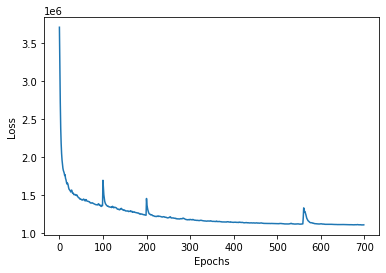

In [ ]:
import matplotlib.pyplot as plt
plt.ion()

fig = plt.figure()
plt.plot(train_loss_avg)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.show()

Evaluate on the Test Set
-------------------------

In [ ]:
# set to evaluation mode
vae.eval()

test_loss_avg, num_batches = 0, 0
for image_batch, _ in dataloader:
    
    with torch.no_grad():
    
        image_batch = image_batch.to(device)

        # vae reconstruction
        image_batch_recon, latent_mu, latent_logvar = vae(image_batch)

pa        # reconstruction error
        loss = vae_loss(image_batch_recon, image_batch, latent_mu, latent_logvar)

        test_loss_avg += loss.item()
        num_batches += 1
    
test_loss_avg /= num_batches
print('average reconstruction error: %f' % (test_loss_avg))

average reconstruction error: 1414216.325000


Visualize Reconstructions
--------------------------

Original images


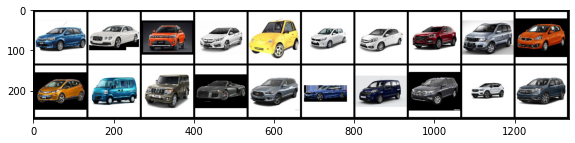

VAE reconstruction:


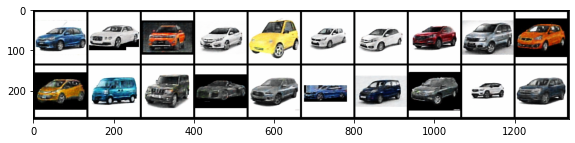

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
plt.ion()

import torchvision.utils

vae.eval()

# This function takes as an input the images to reconstruct
# and the name of the model with which the reconstructions
# are performed
def to_img(x):
    # x = x.clamp(0, 1)
    return x

def show_image(img):
    img = to_img(img)
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))

def visualise_output(images, model):

    with torch.no_grad():
    
        images = images.to(device)
        images, _, _ = model(images)
        images = images.cpu()
        images = to_img(images)
        np_imagegrid = torchvision.utils.make_grid(images[1:21], 10, 5).numpy()
        plt.imshow(np.transpose(np_imagegrid, (1, 2, 0)))
        plt.show()

images, labels = iter(dataloader).next()

# First visualise the original images
print('Original images')
plt.figure(figsize=(10, 2))
show_image(torchvision.utils.make_grid(images[1:21],10,5))
plt.show()

# Reconstruct and visualise the images using the vae
print('VAE reconstruction:')
plt.figure(figsize=(10, 2))
visualise_output(images, vae)

In [ ]:
torch.save(vae.decoder, f"/content/drive/My Drive/vae_decoder.pt")

/usr/local/lib/python3.6/dist-packages/torch/serialization.py:402: UserWarning: Couldn't retrieve source code for container of type Decoder. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


Interpolate in Latent Space
----------------------------

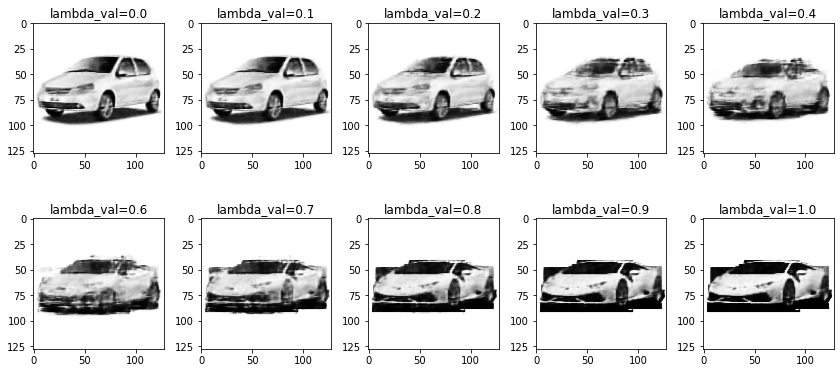

In [ ]:
vae.eval()

def interpolation(lambda1, model, img1, img2):
    
    with torch.no_grad():
    
        # latent vector of first image
        img1 = img1.to(device)
        latent_1, _ = model.encoder(img1)

        # latent vector of second image
        img2 = img2.to(device)
        latent_2, _ = model.encoder(img2)

        # interpolation of the two latent vectors
        inter_latent = lambda1* latent_1 + (1- lambda1) * latent_2

        # reconstruct interpolated image
        inter_image = model.decoder(inter_latent)
        inter_image = inter_image.cpu()

        return inter_image
    
# sort part of test set by digit
# digits = [[] for _ in range(10)]
"""
cars = []
for img_batch, label_batch in dataloader:
    for i in range(img_batch.size(0)):
      cars.append(img_batch[i:i+1])
        # digits[label_batch[i]].append(img_batch[i:i+1])
    # if sum(len(d) for d in digits) >= 1000:
    #     break;
"""

# interpolation lambdas
lambda_range=np.linspace(0,1,10)

fig, axs = plt.subplots(2, 5, figsize=(15, 6))
fig.subplots_adjust(hspace = .5, wspace=.001)
axs = axs.ravel()

for ind, l in enumerate(lambda_range):
    inter_image=interpolation(float(l), vae, cars[17], cars[0])
   
    inter_image = to_img(inter_image)
    
    image = inter_image.numpy()
   
    axs[ind].imshow(image[0,0,:,:], cmap='gray')
    axs[ind].set_title('lambda_val='+str(round(l,1)))
plt.show() 

Sample Latent Vector from Prior (VAE as Generator)
-------------------------------------------------

A VAE can generate new cars by drawing latent vectors from the prior distribution. Although the generated digits are not perfect, they are usually better than for a non-variational Autoencoder.

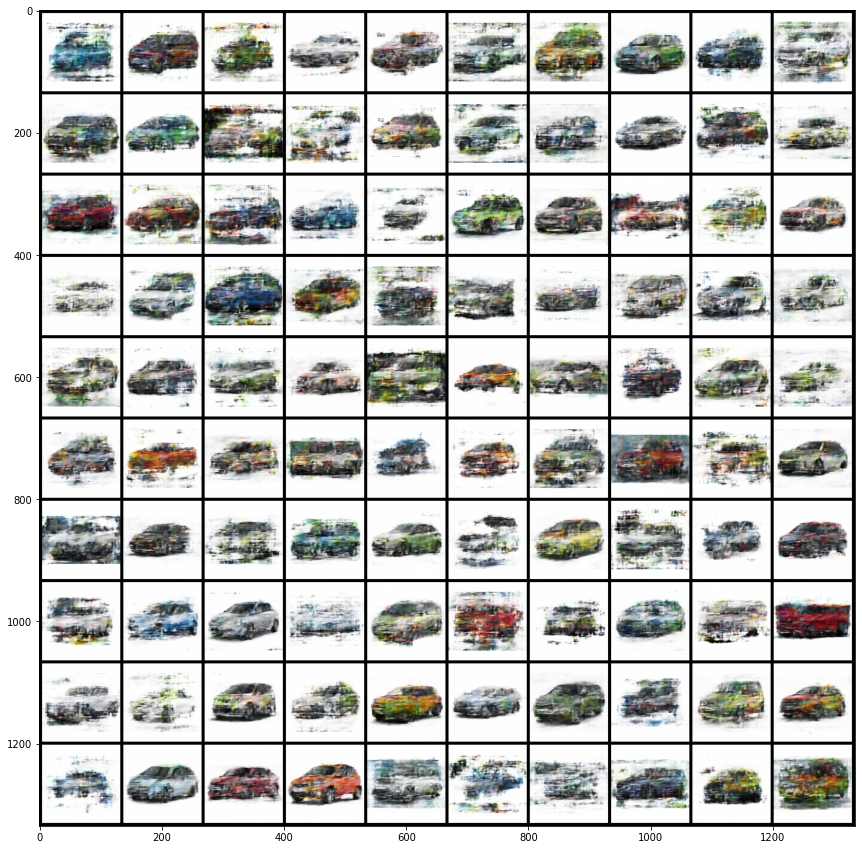

In [ ]:
vae.eval()

with torch.no_grad():

    # sample latent vectors from the normal distribution
    latent = torch.randn(128, latent_dims, device=device)

    # reconstruct images from the latent vectors
    # latent = vae.encode()
    img_recon = vae.decoder(latent)
    img_recon = img_recon.cpu()

    fig, ax = plt.subplots(figsize=(15, 15))
    show_image(torchvision.utils.make_grid(img_recon.data[:100],10,5))
    plt.show()

# Testing

In [ ]:
model = torch.load('/content/drive/My Drive/vae.pt')

In [ ]:
model.latent_sample

In [ ]:
def show_image(img):
    # img = to_img(img)
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))

In [ ]:
import torchvision

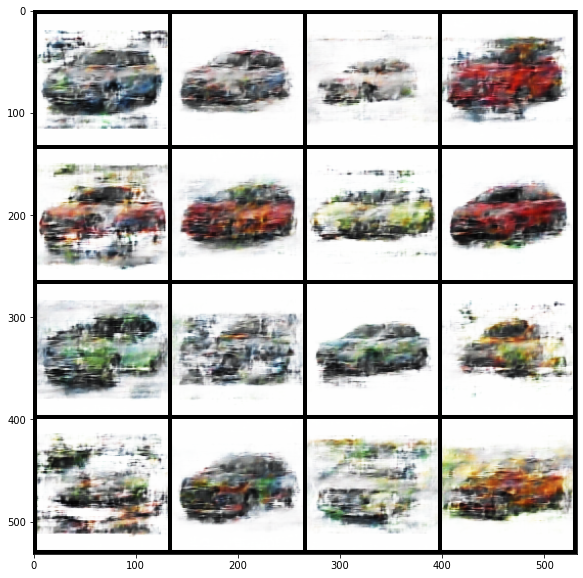

In [ ]:
vae.eval()

with torch.no_grad():

    # sample latent vectors from the normal distribution
    latent = torch.randn(16, latent_dims, )#device=device)

    # reconstruct images from the latent vectors
    # latent = vae.encode()
    img_recon = vae.decoder(latent)
    img_recon = img_recon.cpu()

    fig, ax = plt.subplots(figsize=(10, 10))
    show_image(torchvision.utils.make_grid(img_recon.data,4,4))
    plt.show()

In [ ]:
torch.save(model.state_dict(), 'vae.pth')

In [ ]:
vae = VariationalAutoencoder()

In [ ]:
vae.load_state_dict(torch.load('vae.pth'))

<All keys matched successfully>

In [ ]:
transform=transforms.Compose([
                               transforms.Resize(128),
                               transforms.CenterCrop(128),
                               transforms.ToTensor(),
                              #  transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
                           ])

In [ ]:
from PIL import Image
img = Image.open('car.jpg')
img = transform(img).unsqueeze(0)

In [ ]:
with torch.no_grad():  
  latent_mu, latent_logvar = vae.encoder(img)
  latent = vae.latent_sample(latent_mu, latent_logvar)
  x_recon = vae.decoder(latent)

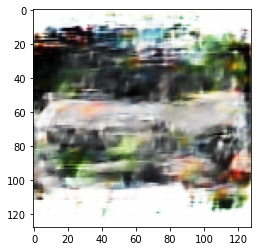

In [ ]:
show_image(x_recon[0])